In [24]:
import os
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import IPython.display as IPdisplay
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image


### Load and read the training data

In [25]:
# Random seed 
torch.manual_seed(10001)

# Read the data and convert it into tensor
train = pd.read_csv('N:/Complex_system/data/lorenz/xyz.csv')
train_tensor = torch.tensor(train.values)


### Plot single data variable 

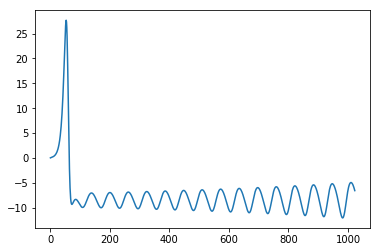

In [26]:
plt.plot(train.values[:,1][:1024])  # y variable
plt.show()

### Scale the input: Haven't plotted the result; Model shows no learning for scaled input tensors

In [27]:
# from sklearn.preprocessing import MinMaxScaler

# x_scaler = MinMaxScaler()

# x_train_scaled = x_scaler.fit_transform(train_tensor[:99000])

In [28]:
# print(x_train_scaled,x_train_scaled.shape)

### Load Data

In [29]:
# Batch size
bs = 1024

# train_data_loader = torch.utils.data.DataLoader(x_train_scaled, batch_size=bs, shuffle=False)
train_data_loader = torch.utils.data.DataLoader(train_tensor, batch_size=bs,drop_last=True, shuffle=False)

# NOTE: Shuffle is set to false to preserve the sequence in data

#### Prechecks on data loader

In [30]:
batch = list(train_data_loader)[0]  # [bs,inp_dim]
print(batch.shape)


torch.Size([1024, 3])


### VAE model

##### Auto-Encoding Variational Bayes; Diederik P Kingma, Max Welling: https://arxiv.org/pdf/1312.6114.pdf

In [31]:
class VAE(nn.Module):
    def __init__(self, in_dim = 3, hidden_dim = 512, n_layers = 2, out_dim =3 ,z_dim= 10):
        
        super(VAE, self).__init__()
        
        # HYPERPARAMETERS
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        # ACTIVATION FUNCTIONS
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # ENCODER
        self.encoder_lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)                                  
#         self.encoder_output = nn.Linear(hidden_dim, z_dim*2)
        self.encoder_output = nn.Linear(hidden_dim, hidden_dim)
        
        # DECODER
#         self.decoder_lstm = nn.LSTM(z_dim, hidden_dim, n_layers, batch_first=True) 
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.decoder_output = nn.Linear(hidden_dim, out_dim)
        
     
    # LATENT SAMPLER
    def reparameterize(self, mu, logvar):
        
        std = logvar.mul(0.5).exp_()
        esp = Variable(torch.randn(*mu.size())).cuda()
        z = mu + std * esp
        return z
                                          
    def forward(self, x):
        
        # Encoder
        enc_hidden = self._init_hidden()   
        enc,_ = self.encoder_lstm(x,enc_hidden)
        enc = self.relu(enc)

        # Reparameterize
        z_var = self.encoder_output(enc)
        mu,logvar = torch.chunk(z_var, 2, dim=2)     
        z = self.reparameterize(mu, logvar)
        
        # Decoder
        dec_hidden = self._init_hidden()
#         dec,_ = self.decoder_lstm(z,dec_hidden)
        dec,_ = self.decoder_lstm(enc,dec_hidden)
#         dec = self.relu(dec)
        dec = self.decoder_output(dec)
        
        return dec, mu, logvar
    
    
    def _init_hidden(self):
        return (torch.zeros(self.n_layers, bs, self.hidden_dim).cuda(), torch.zeros(self.n_layers, bs, self.hidden_dim).cuda())
        

### Initiate model instance

In [32]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (encoder_lstm): LSTM(3, 512, num_layers=2, batch_first=True)
  (encoder_output): Linear(in_features=512, out_features=512, bias=True)
  (decoder_lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (decoder_output): Linear(in_features=512, out_features=3, bias=True)
)

### Loss function

In [33]:
def loss_fn(recon_x, x, mu, logvar,eps):
    
#     BCE = F.binary_cross_entropy(recon_x + eps, x, size_average=False)

    RMSE = torch.sqrt(torch.mean((recon_x-x)**2))
    
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())

    return RMSE

### Training

In [34]:
# Training hyperparameters

epochs = 10
eps = torch.Tensor([1e-10]).cuda()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

pred = []
for epoch in range(epochs):
    for idx, x in enumerate(train_data_loader):
         
        x = x.unsqueeze(1).float().cuda()  # [bs,1,inp_dim]
        recon_x, mu, logvar = vae(x)   
        loss = loss_fn(recon_x, x, mu, logvar,eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
        if epoch == epochs-1:
            pred.append(recon_x.cpu().detach().squeeze().numpy())
            
        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))
            
            
          

Epoch[1/10] Loss: 0.016
Epoch[2/10] Loss: 0.008
Epoch[3/10] Loss: 0.008
Epoch[4/10] Loss: 0.002
Epoch[5/10] Loss: 0.001
Epoch[6/10] Loss: 0.001
Epoch[7/10] Loss: 0.001
Epoch[8/10] Loss: 0.000
Epoch[9/10] Loss: 0.001
Epoch[10/10] Loss: 0.000


In [35]:
checkpoint = {'model': VAE(),
          'state_dict': vae.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint-lorenzrmse.pth')

C:\Users\saran\Anaconda3\envs\tensor\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Data post processing and ploting functions

In [36]:
# Convert N-d array/tensor into 2-D array
def ND22D(ndarray,n_columns):
    d = np.asarray(ndarray)  
    f = np.asarray(d.flatten())  # Flatten the array into 1d
    g = f.reshape(f.shape[0]//n_columns,n_columns)  # Reshape the array with target columns
    return g


In [73]:
# Target folder to save the images

save_folder = 'dl_models/lorenz_img'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [51]:
# Plot the system in 3 dimensions
def plot_lorenz(pxyz,xyz, n):
    
    """
    pxyz - Predicted trajectory
    xyz - Actual trajectory
    n - Every n-th point in the data"""
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca(projection='3d')
    ax.xaxis.set_pane_color((1,1,1,1))
    ax.yaxis.set_pane_color((1,1,1,1))
    ax.zaxis.set_pane_color((1,1,1,1))
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.7,label = 'Training trajectory')
    
    px = pxyz[:, 0]
    py = pxyz[:, 1]
    pz = pxyz[:, 2]
    ax.plot(px, py, pz, color='r', alpha=0.7, linewidth=0.7, label = 'Predicted trajectory ')
    
    ax.set_xlim((-30,30))
    ax.set_ylim((-30,30))
    ax.set_zlim((0,50))
    ax.set_title('Lorenz system attractor')
    plt.legend()
    
    plt.savefig('{}/{:03d}.png'.format(save_folder, n), dpi=60, bbox_inches='tight', pad_inches=0.1)
    plt.close()

In [52]:
g= ND22D(pred,3)
# plot_lorenz(g,train.values[:g.shape[0]],1)


print(len(list(g)),len(list(train.values[:len(g)])))


99328 99328


In [79]:
# Return a list in iteratively larger chunks
def get_chunks(full_list, size):
    size = max(1, size)
    chunks = [full_list[0:i] for i in range(1, len(full_list) + 1, size)]
    return chunks


# Get incrementally larger chunks of the time points, to reveal the attractor one frame at a time
chunks_g = get_chunks(list(g)[:5000], size=30)

In [80]:
chunks_train = get_chunks(list(train.values[:len(g)])[:5000],size = 30)

In [81]:
print(len(chunks_train),len(chunks_g))

167 167


In [ ]:

# Plot each set of points from both actual and predicted sets, one at a time, saving each plot
for n, _ in enumerate(chunks_g):
    plot_lorenz(np.asarray(chunks_g[n]),np.asarray(chunks_train[n]), n)


In [ ]:
# Note there is another import as Image Ipython display. GIF works with PIL only
from PIL import Image,ImageFile
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Count number of images generated by the model in the target folder
files = os.listdir('N:/Complex_system/dl_models/dl_models/lorenz_img') 
tot_imgs =  len(files)

# create a tuple of display durations, one for each frame
first_last = 100 #show the first and last frames for 100 ms
standard_duration = 100 #show all other frames for 5 ms
durations = tuple([first_last] + [standard_duration] * (tot_imgs - 2) + [first_last])

# load all the static images into a list
images = [Image.open(image) for image in glob.glob('{}/*.png'.format(save_folder))]
gif_filepath = 'N:/Complex_system/dl_models/vae_lstm_lorenz.gif'

# save as an animated gif
gif = images[0]
gif.info['duration'] = durations #ms per frame
gif.info['loop'] = 0 #how many times to loop (0=infinite)
gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])

# verify that the number of frames in the gif equals the number of image files and durations
Image.open(gif_filepath).n_frames == len(images) == len(durations)

IPdisplay.Image(url=gif_filepath)